<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/08_intro_to_NLP_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (e.g.: sequences of text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq)

## Check for GPU

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-11-08 16:49:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-08 16:49:27 (84.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset
The dataset we'll be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not)

See the original source here:

https://www.kaggle.com/competitions/nlp-getting-started


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-11-08 16:49:37--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-11-08 16:49:37 (88.5 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualize the data

Reading and writing files in Python:
https://realpython.com/read-write-files-python/

BUT you can use Pandas

Load and preprocess data in tf: https://www.tensorflow.org/tutorials/load_data/csv?hl=pl

In [4]:
import pandas as pd
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training df
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class - balanced or not
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In case the data was more imbalanced:

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pl

In [8]:
# how many total smaples are there
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Visualize random training samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}","(real disaster)" if target>0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Rocky fire in Northern California swells to 60000 acres; 12000 evacuated http://t.co/42gW2i2Q41 Portland #Phoenix #Miami #Atlanta #Casper

---

Target: 0 (not real disaster)
Text:
SCREAMS AT MY OWN MOTHER http://t.co/gBEpdi0WzT

---

Target: 0 (not real disaster)
Text:
@alexbelloli well now I know lol

---

Target: 0 (not real disaster)
Text:
@orbette more like BLOWN UP amirite

---

Target: 1 (real disaster)
Text:
RT : Why Sweden Isn't Venezuela: There have been a few days of rioting in Venezuela with the riots directed at grÛ_ http://t.co/GJfd85vuf2

---



### Split data into training and validation datasets



In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of data for validation split
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

Tokenization, Embedding

Word2vec embedding:
http://jalammar.github.io/illustrated-word2vec/

In [14]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary/dictionary. If none, there's no cap on the size of the vocabulary. If set to an integer, every word that doesn't fit into the dictionary is tokenized as <OOV>
                                    standardize="lower_and_strip_punctuation", # turns all uppercase to lowercase and removes dots, spaces etc
                                    split="whitespace", # text is split into tokens with whitespace
                                    ngrams=None, # whether to arrange text into n-word groups
                                    output_mode="int", # assigns an int token to every word
                                    output_sequence_length=None, # converts every string into a sequence of the same length - the length of the longest sequence - and adds 0's at the end if words are absent
                                    pad_to_max_tokens=False)

In [16]:
len(train_sentences[0].split())

7

In [17]:
# Find the average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in the vocabulary
max_length =15 # how many words in a tweet does the model see

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length) # the vectorizer truncates or pads the tweets to this length

In [19]:
# fit the text vectorizer (it should be called tokenizer) to the training set
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and vectorize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:\n{text_vectorizer([random_sentence])}")

Original text:
#Sismo DETECTADO #JapÌ_n 06:32:43 Miyagi Estimated seismic intensity 0 JST #??        

Vectorized version:
[[1475 3054 2918    1 5107 2470  641 2082 1340 2914    0    0    0    0
     0]]


In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocabulary: {len(words_in_vocab)}")
print(f"5 most common words: \n{top_5_words}")

Number of words in vocabulary: 10000
5 most common words: 
['', '[UNK]', 'the', 'a', 'in']


### Creating an embedding using an embedding layer
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

Most cared for parameters in the embedding layer
* `input_dim` = the size of the vocabulary
* `output_dim` = the size of our output embedding vector
* `input_length` = length of sequences being passed into the embedding layer

In [23]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape to the size of our vocabulary
                             output_dim=128, # GPUs work good with multiples of 8
                             input_length=max_length) # how long is each input

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nEmbedded version:\n{embedding(text_vectorizer(random_sentence))}")

Original text:
@noahshack he's hot &amp; he can sing I'm screaming??????        

Embedded version:
[[-0.04689315  0.02342266  0.01316172 ... -0.03295656  0.03916029
   0.0032214 ]
 [-0.04833494  0.01969439  0.04554662 ... -0.04276722  0.00032319
  -0.04709951]
 [ 0.00954496 -0.03651129 -0.00678409 ... -0.01591146 -0.02487835
  -0.04065914]
 ...
 [-0.00133044  0.00757209  0.01717179 ...  0.04046992 -0.00415595
   0.04875577]
 [-0.00133044  0.00757209  0.01717179 ...  0.04046992 -0.00415595
   0.04875577]
 [-0.00133044  0.00757209  0.01717179 ...  0.04046992 -0.00415595
   0.04875577]]


In [25]:
# Check out a single token's embedding
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04689315,  0.02342266,  0.01316172,  0.03944596,  0.00663661,
        0.04745573,  0.01582051,  0.04403509, -0.04477605,  0.00889752,
       -0.04199985,  0.01559495, -0.00138203,  0.01802273, -0.03612813,
        0.0204846 , -0.00633321, -0.00237496, -0.01330649,  0.02641298,
        0.00782619, -0.0228371 ,  0.03411875,  0.02775953,  0.03751628,
        0.03269162, -0.04100474, -0.03658639,  0.03048423, -0.03863353,
        0.04265131,  0.02383163, -0.0117031 , -0.03683394, -0.01823064,
        0.01632949,  0.00247769, -0.04703766,  0.03164477,  0.01884303,
       -0.01195675,  0.00857859, -0.02972512,  0.01429791,  0.02983056,
        0.02360152,  0.03959744, -0.0361207 , -0.02083373,  0.03711107,
        0.01737597,  0.03904319, -0.02480482, -0.03218057,  0.00095422,
       -0.00790703, -0.04194971, -0.02220206,  0.03886057,  0.02340383,
       -0.04737503,  0.00507421,  0.02417589, -0.04707227,  0.04595144,
        0.020510

In [26]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04689315,  0.02342266,  0.01316172,  0.03944596,  0.00663661,
         0.04745573,  0.01582051,  0.04403509, -0.04477605,  0.00889752,
        -0.04199985,  0.01559495, -0.00138203,  0.01802273, -0.03612813,
         0.0204846 , -0.00633321, -0.00237496, -0.01330649,  0.02641298,
         0.00782619, -0.0228371 ,  0.03411875,  0.02775953,  0.03751628,
         0.03269162, -0.04100474, -0.03658639,  0.03048423, -0.03863353,
         0.04265131,  0.02383163, -0.0117031 , -0.03683394, -0.01823064,
         0.01632949,  0.00247769, -0.04703766,  0.03164477,  0.01884303,
        -0.01195675,  0.00857859, -0.02972512,  0.01429791,  0.02983056,
         0.02360152,  0.03959744, -0.0361207 , -0.02083373,  0.03711107,
         0.01737597,  0.03904319, -0.02480482, -0.03218057,  0.00095422,
        -0.00790703, -0.04194971, -0.02220206,  0.03886057,  0.02340383,
        -0.04737503,  0.00507421,  0.02417589, -0.04707227,  0.04595144,
  

## Modelling a text dataset

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

* Model 0: Naive Bayes
* Model 1: Feed-forward NN
* Model 2: LSTM
* Model 3: GRU
* Model 4: Bidirectional-LSTM
* Model 5: 1D CNN
* Model 6: TFHub pretrained feature extractor
* Model 7: Same as 6 but with 10% data

### Model 0: Baseline

Create a baseline as a benchmark for our future experiments

We'll use SKLearn's Multinomial Naive Bayes using the TF-IDF formula to convert words to numbers

First we use non-deep-learning model as a reference because of its speed. Next we use deep learning models to improve the performance.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization pipeline (equivalent to keras.Sequential)
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels) # Equivalent to keras .evaluate method
print(f"Baseline model achieves accuracy of: {baseline_score*100:.2f}%")

Baseline model achieves accuracy of: 79.27%


In [29]:
# Make predictions
model_0_preds = model_0.predict(val_sentences) # just like in keras

### Create a function for comparing performance

We evaluate
* Accuracy
* Precision
* Recall
* F1-score

https://scikit-learn.org/stable/modules/model_evaluation.html


In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1-score of a binary classification
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1-score using "weighted" average to account for label imbalance
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [31]:
# get baseline results
model_0_results = calculate_results(val_labels, model_0_preds)
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: Feed-forward dense model

In [32]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build a functional API
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # Inputs are 1D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the vectorized inputs
x = layers.GlobalAveragePooling1D()(x) # Reduce dimensionality
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
# Compile the model
model_1.compile(optimizer=tf.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [36]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20231108-164940
Epoch 1/5
215/215 [==============================] - 11s 47ms/step - loss: 0.6132 - accuracy: 0.6958 - val_loss: 0.5367 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 6s 30ms/step - loss: 0.4419 - accuracy: 0.8186 - val_loss: 0.4695 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.3480 - accuracy: 0.8586 - val_loss: 0.4579 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.2854 - accuracy: 0.8899 - val_loss: 0.4624 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.2386 - accuracy: 0.9124 - val_loss: 0.4900 - val_accuracy: 0.7913


In [37]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4900 - accuracy: 0.7913


[0.4900335967540741, 0.7913385629653931]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 4ms/step


(762, 1)

In [39]:
model_1_pred_probs[:10]

array([[0.26326627],
       [0.7415724 ],
       [0.99705464],
       [0.09390663],
       [0.10615014],
       [0.93175375],
       [0.9142113 ],
       [0.9916328 ],
       [0.95904714],
       [0.2514711 ]], dtype=float32)

In [40]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [41]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 0.7913385826771654,
 'precision': 0.8003354923296975,
 'recall': 0.7913385826771654,
 'f1': 0.7872372057171038}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(model_0_results.values()))

array([False, False, False,  True])

Baseline is doing better

## Visualize learned embeddings

In [43]:
# Get the vocabulary from the text tokenization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
# Get the weight matirx of embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

Let's see how we can visualize it

https://projector.tensorflow.org/

https://www.tensorflow.org/text/guide/word_embeddings?hl=pl

In [46]:
# Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


In [47]:
# Download foles from colab to import to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent neural networks (RNNs)

RNNs are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the  representation of the later input.

https://www.youtube.com/watch?v=qjrad0V0uJE

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM - long short term memory

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [48]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # when stacking recurrent layers you need to set return_sequences to True. Otherwise the layer reduces dimensions
x = layers.LSTM(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [49]:
# Get s aummary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [50]:
# Compile
model_2.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [51]:
# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231108-165027
Epoch 1/5
215/215 [==============================] - 22s 70ms/step - loss: 0.2223 - accuracy: 0.9199 - val_loss: 0.5718 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 13s 62ms/step - loss: 0.1563 - accuracy: 0.9421 - val_loss: 0.5687 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 12s 56ms/step - loss: 0.1292 - accuracy: 0.9518 - val_loss: 0.6832 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.1051 - accuracy: 0.9607 - val_loss: 0.8527 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0858 - accuracy: 0.9660 - val_loss: 1.0654 - val_accuracy: 0.7835


In [52]:
# Make predictions with model 2
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 8ms/step


array([[2.2161503e-03],
       [5.5788082e-01],
       [9.9979186e-01],
       [9.9780392e-03],
       [4.9026089e-04],
       [9.9920171e-01],
       [9.6624804e-01],
       [9.9984622e-01],
       [9.9971914e-01],
       [3.8446322e-01]], dtype=float32)

In [53]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 0.7834645669291339,
 'precision': 0.7875988615317319,
 'recall': 0.7834645669291339,
 'f1': 0.7806382038884261}

### Model 3: GRU

Gated recurrent unit (GRU) has similar features to LSTM but less trainable parameters

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

In [55]:
# Create the same model but with a GRU cell
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x) # if wished to stack recurrent layers, set return_sequences=True
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [57]:
# Compile the model
model_3.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [58]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231108-165137
Epoch 1/5
215/215 [==============================] - 19s 52ms/step - loss: 0.1518 - accuracy: 0.9403 - val_loss: 0.7909 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0808 - accuracy: 0.9696 - val_loss: 0.7666 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0723 - accuracy: 0.9727 - val_loss: 0.9297 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 10s 47ms/step - loss: 0.0614 - accuracy: 0.9752 - val_loss: 0.9384 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 14s 66ms/step - loss: 0.0540 - accuracy: 0.9764 - val_loss: 1.2161 - val_accuracy: 0.7848


In [59]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[5.8926555e-04],
       [8.3846176e-01],
       [9.9988508e-01],
       [4.7629755e-02],
       [1.3684075e-04],
       [9.9980634e-01],
       [9.8001260e-01],
       [9.9996275e-01],
       [9.9990314e-01],
       [9.5474720e-01]], dtype=float32)

In [60]:
# Convert pred probs to preds
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.7847769028871391,
 'precision': 0.7862392297712013,
 'recall': 0.7847769028871391,
 'f1': 0.7830611097687449}

### Model 4: Bidirectional RNN

Bidirectional RNN feeds the representation of the former as well as the latter element in the sentence to the representation of the current element

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [62]:
# Create the model
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs)

In [63]:
# Get the summary
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.

In [64]:
# Compile model
model_4.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231108-165309
Epoch 1/5
215/215 [==============================] - 21s 68ms/step - loss: 0.1037 - accuracy: 0.9704 - val_loss: 1.1264 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0515 - accuracy: 0.9780 - val_loss: 1.1317 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 15s 69ms/step - loss: 0.0488 - accuracy: 0.9796 - val_loss: 1.3388 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 20s 92ms/step - loss: 0.0423 - accuracy: 0.9801 - val_loss: 1.3221 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0438 - accuracy: 0.9804 - val_loss: 1.5474 - val_accuracy: 0.7651


In [66]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[9.8998714e-03],
       [6.4842403e-01],
       [9.9997622e-01],
       [4.1382100e-02],
       [2.1724627e-05],
       [9.9967515e-01],
       [4.5795700e-01],
       [9.9998873e-01],
       [9.9998230e-01],
       [9.9856734e-01]], dtype=float32)

In [67]:
# Convert to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate the results
model_4_results = calculate_results(val_labels,model_4_preds)
model_4_results

{'accuracy': 0.7650918635170604,
 'precision': 0.7658125387191,
 'recall': 0.7650918635170604,
 'f1': 0.7634031052086162}

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

##  CNN for text and other sequences

Typical structure
`Inputs -> Tokenization -> Embedding -> Conv1D -> Outputs`

### Model 5: Conv1D

In [71]:
# Test the embedding layer, Conv1D and pooling layer
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sequence"])) # turn target sequence into an embedding matrix
conv1d = layers.Conv1D(filters=32,
                       kernel_size=5,
                       strides=1, # default
                       activation="relu",
                       padding="valid") # default
conv1D_test = conv1d(embedding_test) # pass the embedding through a conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_test = max_pool(conv1D_test) # get the max from the previous layer

embedding_test.shape, conv1D_test.shape, max_pool_test.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [72]:
# Start constructing the model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

# Compile the model
model_5.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

# Get a summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20231108-165458
Epoch 1/5
215/215 [==============================] - 7s 30ms/step - loss: 0.1192 - accuracy: 0.9585 - val_loss: 0.9049 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0738 - accuracy: 0.9718 - val_loss: 1.0591 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0611 - accuracy: 0.9759 - val_loss: 1.1098 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0570 - accuracy: 0.9772 - val_loss: 1.2568 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0517 - accuracy: 0.9775 - val_loss: 1.2116 - val_accuracy: 0.7572


In [74]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

24/24 [==============================] - 0s 4ms/step


array([[2.0383655e-01],
       [6.5412968e-01],
       [9.9982244e-01],
       [7.5457305e-02],
       [8.7801737e-07]], dtype=float32)

In [75]:
# Convert probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [76]:
# Evaluate model 5 results
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 0.7572178477690289,
 'precision': 0.7574646046920478,
 'recall': 0.7572178477690289,
 'f1': 0.7557133417830907}

## Transfer learning for NLP

https://huggingface.co/transformers/v3.0.2/index.html

### Model 6: TensorFlow Hub pretrained sentence encoder
https://tfhub.dev/google/universal-sentence-encoder/4

In [77]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you use the universal sentence encoder on a sentence, it turns it into numbers"]) # does tokenization for us
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [78]:
embed_samples[0].shape

TensorShape([512])

In [79]:
# Create keras layer using the pretrained layer from tf hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # blank bc the input to thr layer can be of variable length
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [80]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [81]:
# Train the classifier on top of the USE embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20231108-165608
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.4985 - accuracy: 0.7884 - val_loss: 0.4512 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4146 - accuracy: 0.8139 - val_loss: 0.4424 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4011 - accuracy: 0.8203 - val_loss: 0.4347 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3931 - accuracy: 0.8282 - val_loss: 0.4334 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3861 - accuracy: 0.8308 - val_loss: 0.4293 - val_accuracy: 0.8150


In [82]:
# Make predictions with the USE model
model_6_pred_probs = model_6.predict(val_sentences)
# Convert to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

24/24 [==============================] - 1s 11ms/step


In [83]:
# Calculate results
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1': 0.8134357776936025}

## Model 7: TF Hub USE but only on 10% of data

In [84]:
# Create subsets of 10% of training data
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [85]:
# Check if the subset is representative
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

To clone a model without learned weights you can use the tf.keras.models.clone_model function

https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [86]:
# Create model by tf.keras.models.clone_model function
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(optimizer="Adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [87]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20231108-165640
Epoch 1/5
22/22 [==============================] - 5s 53ms/step - loss: 0.6714 - accuracy: 0.6993 - val_loss: 0.6535 - val_accuracy: 0.7349
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.6113 - accuracy: 0.8029 - val_loss: 0.6005 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5389 - accuracy: 0.8190 - val_loss: 0.5473 - val_accuracy: 0.7638
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4723 - accuracy: 0.8248 - val_loss: 0.5082 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4278 - accuracy: 0.8263 - val_loss: 0.4896 - val_accuracy: 0.7822


In [88]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
# Convert to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
# Calculate results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

24/24 [==============================] - 1s 11ms/step


{'accuracy': 0.7821522309711286,
 'precision': 0.7821792038840996,
 'recall': 0.7821522309711286,
 'f1': 0.7812415177977966}

## Comparing the performace of each of our models

In [89]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional_rnn": model_4_results,
                                  "conv1d": model_5_results,
                                  "use": model_6_results,
                                  "use_10_percent": model_7_results,}).T
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.791339,0.800335,0.791339,0.787237
lstm,0.783465,0.787599,0.783465,0.780638
gru,0.784777,0.786239,0.784777,0.783061
bidirectional_rnn,0.765092,0.765813,0.765092,0.763403
conv1d,0.757218,0.757465,0.757218,0.755713
use,0.814961,0.817255,0.814961,0.813436
use_10_percent,0.782152,0.782179,0.782152,0.781242


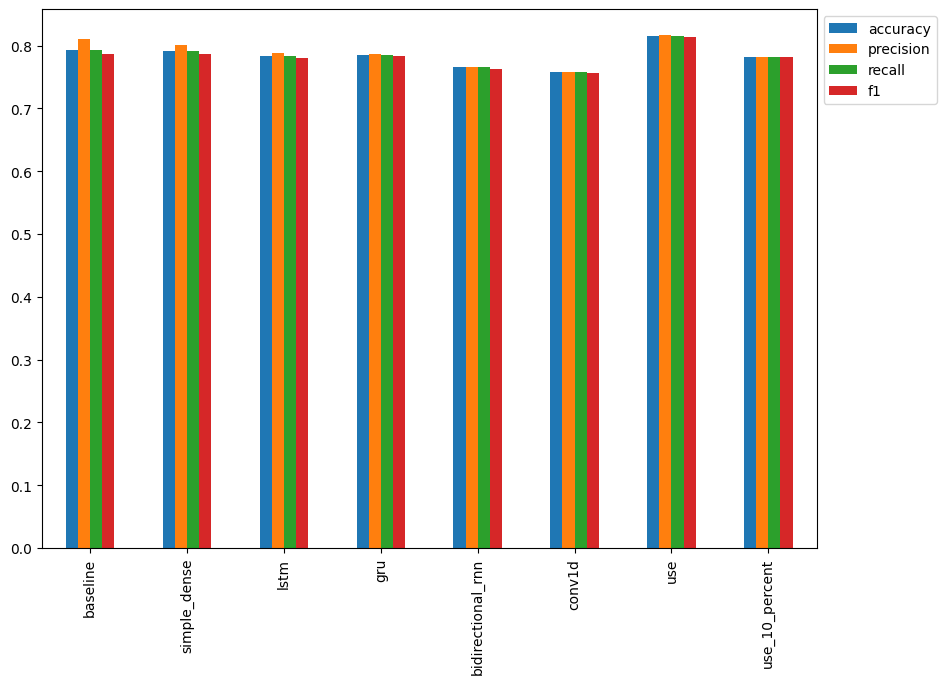

In [90]:
# Plot and compare all of the models results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.,1.));

<Axes: >

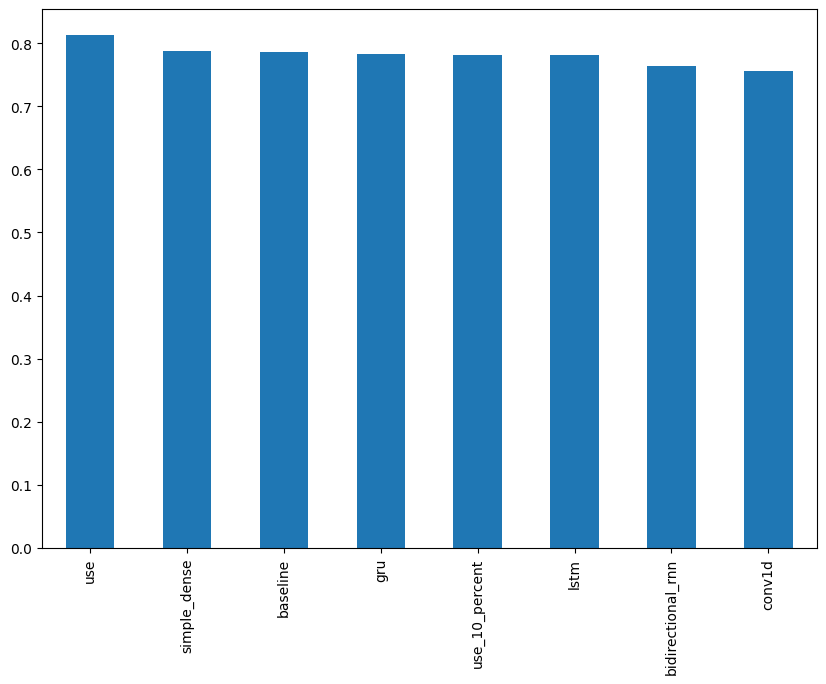

In [91]:
# Sort model results by f1
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Uploading our model results to tensorboard.dev

In [92]:
# View tensorboard logs of our modelling experiments
# Upload Tensorboard records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modelling Experiments ZTM TF course" \
#   --description "Comparing different types of model architectures on the Kaggle Tweets text classification dataset" \
#   --one_shot # exit the uploader once uploading is finished
# TensorBoard is shutting down. Try https://wandb.ai/site instead

## Saving and loading a trained model

https://www.tensorflow.org/tutorials/keras/save_and_load

https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace

Two main formats
* HDF5
* `SavedModel` (default in Google Colab)

In [93]:
# Save the best performing model - model 6 to HDF5 format
model_6.save("model_6.h5") # .h5 to let python know we want it in HDF5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [94]:
# Load model with custom TF Hub layer (required when using HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer}) # key is the type of the custom object and value is the class that the object came from

In [95]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4293 - accuracy: 0.8150


[0.429291695356369, 0.8149606585502625]

In [96]:
# Save the best model to the SavedModel format
model_6.save("model_6_SM_format")

In [97]:
# Load the model
loaded_model_6_SM = tf.keras.models.load_model("model_6_SM_format") # no need to specify custom objects since SavedModel keeps all the info about the model

In [98]:
# Evaluate the SavedModel model
loaded_model_6_SM.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4293 - accuracy: 0.8150


[0.429291695356369, 0.8149606585502625]

## Finding the most wrong examples

* What examples is the model getting wrong
* Which of them are most certain

In [99]:
# Downloading a pretrained model from Google storage to get similar results to Daniel
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-11-08 17:02:17--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.207, 172.217.204.207, 172.217.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  69.7MB/s    in 15s     

2023-11-08 17:02:32 (61.5 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [100]:
# Import the model
model_6_pretrained = tf.keras.models.load_model("/content/08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [104]:
# Make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

24/24 [==============================] - 0s 13ms/step


{'accuracy': 0.8162729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [108]:
# Create a DF with all of our validation data and model predictions of the best performing model
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [112]:
# Find the wrong predictions and sort by prediction probability
most_wrong = val_df[val_df["target"]!=val_df["pred"]].sort_values("pred_probs", ascending=False)
most_wrong[-10:] # false negatives

,text,target,pred,pred_probs
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [121]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target {target}, Pred: {pred}, Prob: {pred_prob}\nText:\n{text}\n")
  print("----\n")

Target 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Targ

In [122]:
# Check the false negatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target {target}, Pred: {pred}, Prob: {pred_prob}\nText:\n{text}\n")
  print("----\n")

Target 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

----

Target 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target 1, Pred: 0.0, Prob: 0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target 1, Pred: 0.0, Prob: 0.04963730648159981
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target 1, Pred: 0.0, Prob: 0.04391849413514137
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target 1, Pred: 0.0, Prob: 0.0420868

## Making predictions on the test dataset

In [125]:
test_sentences = test_df["text"].tolist()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}, Text:\n{test_sample}\n-----\n");

1/1 [==============================] - 0s 46ms/step
Pred: 1, Prob: 0.5322765707969666, Text:
.@CBCNorth see photo Old Lady of the Falls (sacred site) RR says derailed Talston power line to diamond mines in 2010
http://t.co/SxlfSNsPH0
-----

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.1576734036207199, Text:
Got my first damage today  fuckkkkkk
-----

1/1 [==============================] - 0s 42ms/step
Pred: 1, Prob: 0.9352068305015564, Text:
India: Militant 'Overpowered' By Hostages After Attack http://t.co/mkjszGbaWR
-----

1/1 [==============================] - 0s 43ms/step
Pred: 0, Prob: 0.08139878511428833, Text:
@melodores @Hozier *SCREAMS*
-----

1/1 [==============================] - 0s 45ms/step
Pred: 1, Prob: 0.6369391083717346, Text:
#Gabon : Oil and Gas Exploration Takes Seismic Shift in Gabon to Somalia http://t.co/SY8nqTLMD3 ^FJ http://t.co/yjDHoDdjox
-----

1/1 [==============================] - 0s 54ms/step
Pred: 1, Prob: 0.8098872303962708, Text

## The speed/score tradeoff

In [126]:
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1': 0.8134357776936025}

In [127]:
model_0_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [129]:
# Let's make a fcn to measure the prediction time
import time
def pred_timer(model, samples):
  """
  Times how long it takes for a model to predict on samples
  """
  start_time = time.perf_counter() # get the start time
  model.predict(samples)
  end_time = time.perf_counter() # get the end time
  total_time =  end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [130]:
# Calculate model_6 time preformance
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 13ms/step


(0.41129640899998776, 0.0005397590669291177)

In [131]:
# Calculate the baseline model time per pred
model_0_total_pred_time, model_0_time_per_pred = pred_timer(model_0, val_sentences)
model_0_total_pred_time, model_0_time_per_pred

(0.05596594099915819, 7.344611679679553e-05)

In [132]:
model_6_pretrained_results

{'accuracy': 0.8162729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

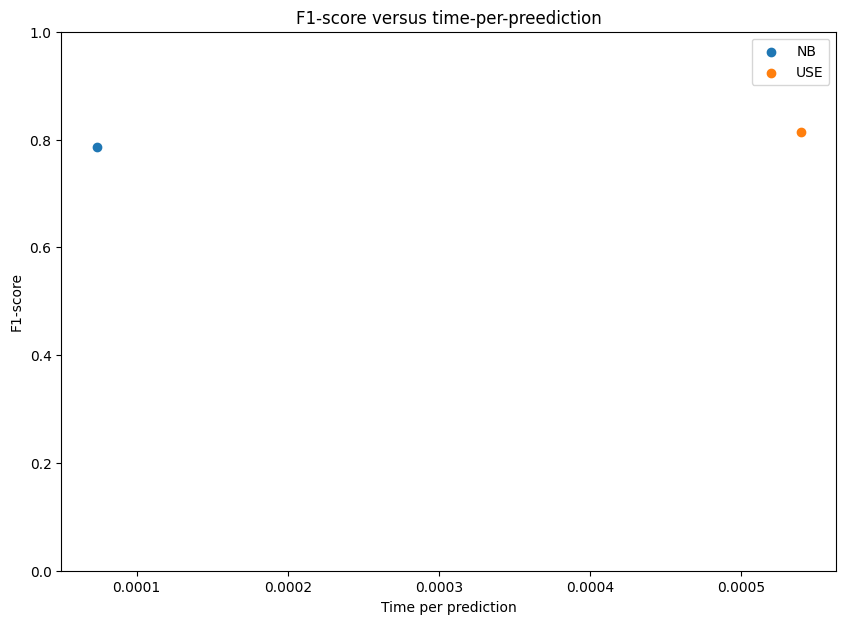

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(model_0_time_per_pred, model_0_results["f1"], label="NB")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="USE")
plt.ylim((0,1))
plt.legend()
plt.title("F1-score versus time-per-preediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");